In [1]:
! pip install albumentations==0.4.6
! pip install efficientnet_pytorch
!pip install imagecodecs

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

import skimage.io
import random
import time
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, accuracy_score

from tqdm.notebook import tqdm

from efficientnet_pytorch import EfficientNet

import warnings
warnings.filterwarnings('ignore')

In [3]:
# https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """Early stops the training if validation kappa doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation kappa improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation kappa improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_kappa_min = -np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_kappa, model):

        score = val_kappa

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_kappa, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_kappa, model)
            self.counter = 0

    def save_checkpoint(self, val_kappa, model):
        '''Saves model when validation kappa increase.'''
        if self.verbose:
            self.trace_func(f'Validation kappa increase ({self.val_kappa_min:.6f} --> {val_kappa:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_kappa_min = val_kappa

In [4]:
DEBUG = True

In [5]:
class Config:
    image_size = tile_size = 256
    n_tiles = 16

    epochs = 1 if DEBUG else 5
    batch_size = 8
    folds = 5
    
    init_lr = 3e-4
    factor_lr = 0.5
    patience_lr = 1

    esp = 7
    N = 100 if DEBUG else 10616

    n_classes = 6
    seed = 42
    num_workers = 4

    model_name = 'efficientnet-b0'
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(Config.seed)

In [6]:
if torch.cuda.is_available():
    print('Working on GPU')
else:
    print('Working on CPU')

Working on GPU


In [7]:
path = '/content/drive/MyDrive/Prostate cancer/Prostate cANcer graDe Assessment'
train_file = 'train_images'

train = pd.read_csv(os.path.join(path, 'train.csv')).iloc[:Config.N, :]
train.shape

(100, 4)

In [8]:
def get_tiles(img, mode=0):
        result = []
        h, w, c = img.shape
        pad_h = (Config.tile_size - h % Config.tile_size) % Config.tile_size + ((Config.tile_size * mode) // 2)
        pad_w = (Config.tile_size - w % Config.tile_size) % Config.tile_size + ((Config.tile_size * mode) // 2)

        img2 = np.pad(img,[[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2,pad_w - pad_w//2], [0,0]], constant_values=255)
        img3 = img2.reshape(
            img2.shape[0] // Config.tile_size,
            Config.tile_size,
            img2.shape[1] // Config.tile_size,
            Config.tile_size,
            3
        )

        img3 = img3.transpose(0,2,1,3,4).reshape(-1, Config.tile_size, Config.tile_size,3)
        n_tiles_with_info = (img3.reshape(img3.shape[0],-1).sum(1) < Config.tile_size ** 2 * 3 * 255).sum()
        if len(img3) < Config.n_tiles:
            img3 = np.pad(img3,[[0,Config.n_tiles-len(img3)],[0,0],[0,0],[0,0]], constant_values=255)
        idxs = np.argsort(img3.reshape(img3.shape[0],-1).sum(-1))[:Config.n_tiles]
        img3 = img3[idxs]
        for i in range(len(img3)):
            result.append({'img':img3[i], 'idx':i})
        return result, n_tiles_with_info >= Config.n_tiles

In [9]:
class PlantData(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 n_tiles=Config.n_tiles,
                 tile_mode=0,
                 rand=False,
                 transform=None,
                ):

        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.tile_mode = tile_mode
        self.rand = rand
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        tiff_file = os.path.join(os.path.join(path, train_file), f'{img_id}.tiff')
        image = skimage.io.MultiImage(tiff_file)[1]
        tiles, OK = get_tiles(image, self.tile_mode)

        if self.rand:
            idxes = np.random.choice(list(range(self.n_tiles)), self.n_tiles, replace=False)
        else:
            idxes = list(range(self.n_tiles))

        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((Config.image_size * n_row_tiles, Config.image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
    
                if len(tiles) > idxes[i]:
                    this_img = tiles[idxes[i]]['img']
                else:
                    this_img = np.ones((self.image_size, self.image_size, 3)).astype(np.uint8) * 255
                this_img = 255 - this_img
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * Config.image_size
                w1 = w * Config.image_size
                images[h1:h1+Config.image_size, w1:w1+Config.image_size] = this_img

        if self.transform is not None:
            images = self.transform(image=images)['image']
        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)

        label_dummies = pd.get_dummies(self.df['isup_grade']).values
        label = torch.from_numpy(label_dummies[index]).unsqueeze(-1)
        return torch.tensor(images), torch.tensor(label)

In [10]:
def PlantModel(model_name=Config.model_name):
    model = EfficientNet.from_pretrained(Config.model_name)
    fc = model._fc.in_features
    model._fc = nn.Sequential(nn.Linear(fc, 1000, bias=True),
                              nn.ReLU(),
                              nn.Dropout(p=.5),
                              nn.Linear(1000, Config.n_classes, bias=True))
    
    return model

In [11]:
def train_one_fold(i_fold, model, criterion, optimizer, scheduler, dataloader_train, dataloader_val):
    
    train_fold_results = []
    stop_early = EarlyStopping(patience=Config.esp, verbose=True)
    
    for epoch in range(1, Config.epochs+1):
      print(time.ctime(), 'Epoch:',epoch, '| LR:',optimizer.param_groups[0]["lr"])

      model.train()
      
      train_preds = None
      train_labels = None
      for i, (images, labels) in enumerate(tqdm(dataloader_train)):
        images = images.to(Config.device, dtype=torch.float)
        labels = labels.to(Config.device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.squeeze(-1))
        loss.backward()
        optimizer.step()

        if train_preds is None:
          train_preds = outputs.detach().cpu()
          train_labels = labels.detach().cpu()
        else:
          train_preds = torch.cat((train_preds, outputs.detach().cpu()), dim=0)
          train_labels = torch.cat((train_labels, labels.detach().cpu()), dim=0)

      tr_loss = 0
      tr_acc = 0
      tr_kappa = 0

      tr_loss = criterion(train_preds, train_labels.squeeze(-1)).item()
      tr_acc = accuracy_score(train_preds.argmax(1), train_labels.argmax(1))
      tr_kappa = cohen_kappa_score(train_preds.argmax(1), train_labels.argmax(1), weights='quadratic')
        
          
      model.eval()
      
      val_preds = None
      val_labels = None
      for i, (images, labels) in enumerate(tqdm(dataloader_val)):
        images = images.to(Config.device, dtype=torch.float)
        labels = labels.to(Config.device, dtype=torch.float)
                    
        with torch.no_grad():
            outputs = model(images)
            if val_preds is None:
              val_preds = outputs.detach().cpu()
              val_labels = labels.detach().cpu()
            else:
              val_preds = torch.cat((val_preds, outputs.detach().cpu()), dim=0)
              val_labels = torch.cat((val_labels, labels.detach().cpu()), dim=0)

      val_loss = 0
      val_acc = 0
      val_kappa = 0

      val_loss = criterion(val_preds, val_labels.squeeze(-1)).item()
      val_acc = accuracy_score(val_preds.argmax(1), val_labels.argmax(1))
      val_kappa = cohen_kappa_score(val_preds.argmax(1), val_labels.argmax(1), weights='quadratic')
              
      msg = ('[{}/{}] '.format(epoch, Config.epochs) + 
          f'train_loss: {tr_loss:.5f} ' + f'valid_loss: {val_loss:.5f} ' + 
          f'train_acc: {tr_acc:.5f} ' + f'valid_acc: {val_acc:.5f} ' +
          f'train_kappa: {tr_kappa:.5f} ' + f'valid_kappa: {val_kappa:.5f} ')
      print(msg)
        
      train_fold_results.append({
          'fold': i_fold,
          'epoch': epoch,
          'train_loss': tr_loss,
          'valid_loss': val_loss,
          'train_acc': tr_acc,
          'valid_acc': val_acc,
          'train_kappa': tr_kappa,
          'valid_kappa': val_kappa,
      })
      
      scheduler.step(val_kappa)
      # early_stopping needs the validation kappa to check if it has increase, 
      # and if it has, it will make a checkpoint of the current model
      stop_early(val_kappa, model)
      if stop_early.early_stop:
          print("Early stopping")
          break
      print('')
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))
    
    return model, train_fold_results

In [12]:
transforms_train = A.Compose([
    A.Transpose(p=0.7),
    A.VerticalFlip(p=0.7),
    A.HorizontalFlip(p=0.7),
])

transforms_val = A.Compose([])

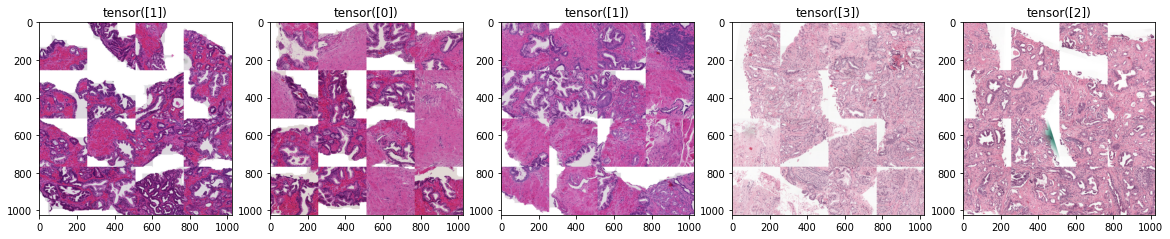

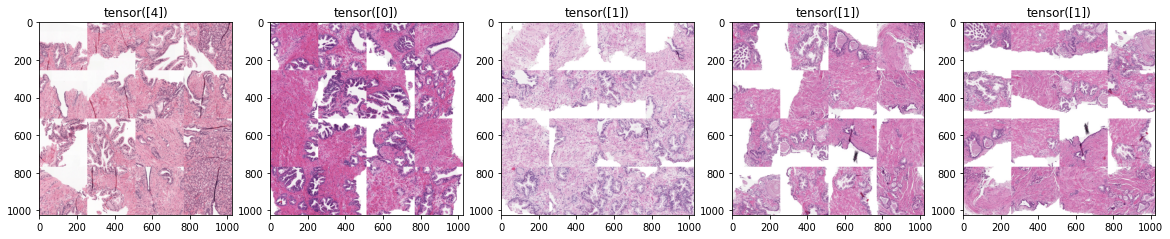

In [13]:
from pylab import rcParams
dataset_show = PlantData(train, Config.image_size , Config.n_tiles, 0, transform=transforms_train)

rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(label.argmax(0))

In [14]:
folds = StratifiedKFold(n_splits=Config.folds, shuffle=True, random_state=Config.seed)
train_results = []

for i_fold, (train_idx, valid_idx) in enumerate(folds.split(train, train.isup_grade.values)):
  print('#'*60)
  print('#'*60)
  print('\t\t\tFOLD {}/{}'.format(i_fold+1, Config.folds))
  print('#'*60)
  print('#'*60)
  
  valid = train.iloc[valid_idx]
  valid.reset_index(drop=True, inplace=True)
  
  tra = train.iloc[train_idx]
  tra.reset_index(drop=True, inplace=True)

  dataset_train =  PlantData(tra, Config.image_size , Config.n_tiles, 0, transform=transforms_train)
  dataset_valid =  PlantData(valid, Config.image_size , Config.n_tiles, 0, transform=transforms_val)

  dataloader_train = DataLoader(dataset_train, batch_size=Config.batch_size, num_workers=Config.num_workers, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=Config.batch_size, num_workers=Config.num_workers, shuffle=False)

  model = PlantModel()
  model.to(Config.device);

  criterion = nn.BCEWithLogitsLoss()

  optimizer = optim.Adam(model.parameters(), lr=Config.init_lr)
  scheduler_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=Config.factor_lr, 
                                                            patience=Config.patience_lr ,verbose=True)

  model, train_fold_results = train_one_fold(i_fold+1, model, criterion, optimizer, scheduler_lr, dataloader_train, dataloader_valid)

  train_results += train_fold_results
  torch.save(model.state_dict(), f'checkpoint_Fold#{i_fold+1}.pt')

############################################################
############################################################
			FOLD 1/5
############################################################
############################################################
Loaded pretrained weights for efficientnet-b0
Sat Apr 24 19:59:52 2021 Epoch: 1 | LR: 0.0003



[1/1] train_loss: 0.57224 valid_loss: 0.53124 train_acc: 0.18750 valid_acc: 0.35000 train_kappa: 0.07168 valid_kappa: 0.40449 
Validation kappa increase (-inf --> 0.404494).  Saving model ...

############################################################
############################################################
			FOLD 2/5
############################################################
############################################################
Loaded pretrained weights for efficientnet-b0
Sat Apr 24 20:00:43 2021 Epoch: 1 | LR: 0.0003



[1/1] train_loss: 0.55613 valid_loss: 0.56010 train_acc: 0.27500 valid_acc: 0.25000 train_kappa: -0.02473 valid_kappa: 0.60474 
Validation kappa increase (-inf --> 0.604743).  Saving model ...

############################################################
############################################################
			FOLD 3/5
############################################################
############################################################
Loaded pretrained weights for efficientnet-b0
Sat Apr 24 20:01:06 2021 Epoch: 1 | LR: 0.0003



[1/1] train_loss: 0.56116 valid_loss: 0.53479 train_acc: 0.20000 valid_acc: 0.40000 train_kappa: -0.06098 valid_kappa: 0.24009 
Validation kappa increase (-inf --> 0.240088).  Saving model ...

############################################################
############################################################
			FOLD 4/5
############################################################
############################################################
Loaded pretrained weights for efficientnet-b0
Sat Apr 24 20:01:29 2021 Epoch: 1 | LR: 0.0003



[1/1] train_loss: 0.56542 valid_loss: 0.47862 train_acc: 0.12500 valid_acc: 0.25000 train_kappa: -0.10017 valid_kappa: 0.05993 
Validation kappa increase (-inf --> 0.059929).  Saving model ...

############################################################
############################################################
			FOLD 5/5
############################################################
############################################################
Loaded pretrained weights for efficientnet-b0
Sat Apr 24 20:01:51 2021 Epoch: 1 | LR: 0.0003



[1/1] train_loss: 0.55392 valid_loss: 0.54161 train_acc: 0.23750 valid_acc: 0.35000 train_kappa: 0.12463 valid_kappa: 0.10526 
Validation kappa increase (-inf --> 0.105263).  Saving model ...



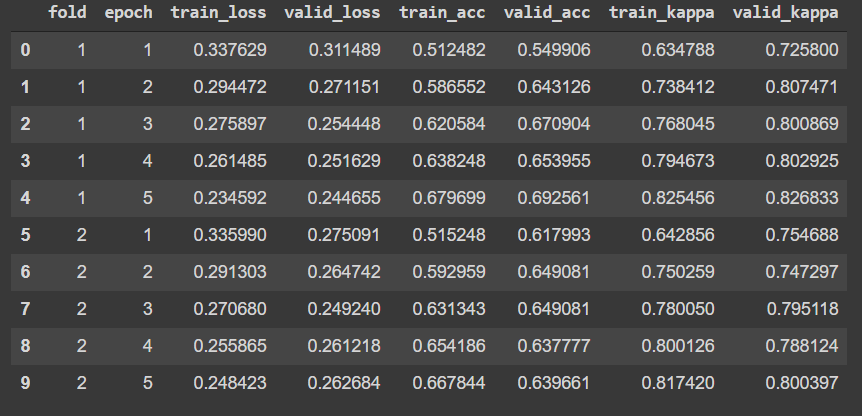

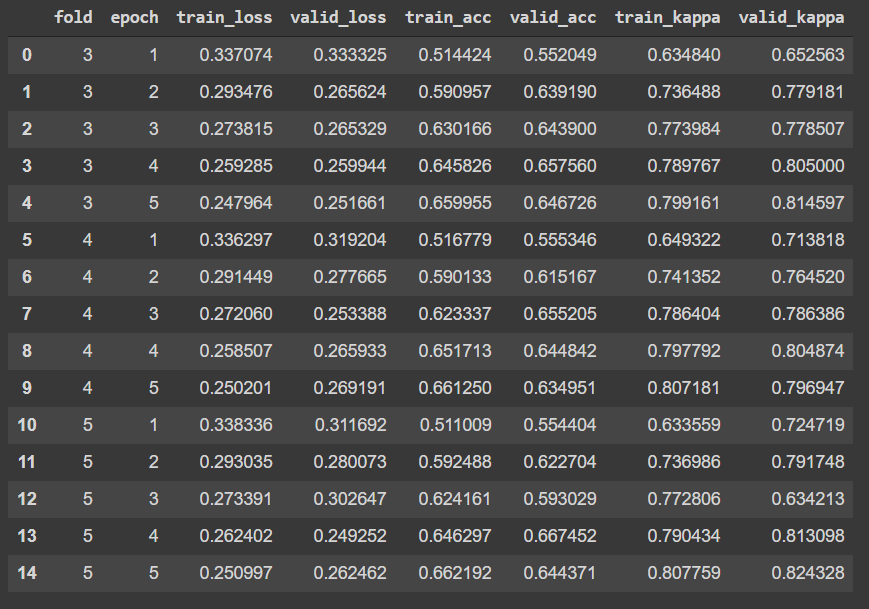

In [15]:
# pd.DataFrame(train_results)
display(Image('/content/Fold(1 & 2).PNG'))
display(Image('/content/Fold(3 & 4 & 5).PNG'))